In [29]:
!pip install lightgbm 


     ---------------------------------------- 1.0/1.0 MB 2.1 MB/s eta 0:00:00


<h1> Introduction </h1>
<pre> <h4>This program contains the functions needed for the handling of the dataset
previously generated by the clustering function. It also contains the
classification model class, and will attempt to explain the reasoning behind
decisions taken by the model. </h4> </pre>




<h2>Imports Needed </h2>

In [1]:
# classification program - Harshiv, 2022
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier # used to implement Support Vector Machine Classifier.
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.neighbors import KNeighborsClassifier
import shap as sp
from shap import waterfall_plot
import matplotlib.pyplot as plt

<h2> Data loading class </h2>
<pre> 
A class that defines the data loading, and splitting pipeline
It brings our data and processes it, in preparation for futher classification 
operations, using the IterativeImputer function from scikit-learn.
        </pre>


In [7]:
class data():

    def __init__(data): 
        data.X = pd.read_csv('OriginalSoilDataset.csv')[pd.read_csv('OriginalSoilDataset.csv').keys()[2:10]]
        data.labels = data.X.keys()
        data.Y1 = pd.read_csv('datalabelsforparams.csv')
        data.Y2 = pd.read_csv('relativesoillabels.csv')
        data.clean_data()
        data.y_labels = data.labels.insert(len(data.labels),'Relative Soil Fertility')
        # really long y declaration, basically strips "point_id" attribute from the Y1 dataset and combines both Y1 and Y2 datasets into 1 unified y dataset.
        data.y = pd.DataFrame(np.c_[np.c_[np.c_[np.c_[np.c_[np.c_[np.c_[np.c_[np.hsplit(data.Y1,9)[1],np.hsplit(data.Y1,9)[2]],np.hsplit(data.Y1,9)[3]],np.hsplit(data.Y1,9)[4]],np.hsplit(data.Y1,9)[5]],np.hsplit(data.Y1,9)[6]],np.hsplit(data.Y1,9)[7]],np.hsplit(data.Y1,9)[8]],np.hsplit(data.Y2,2)[1]],columns = data.y_labels)
        data.X_train, data.X_test, data.y_train,data.y_test = train_test_split(data.X,data.y,test_size=0.2)
        data.X_train = pd.DataFrame(data.X_train,columns = data.labels)
        data.X_test = pd.DataFrame(data.X_test,columns = data.labels)
        

    def clean_data(data):
        # removes all the NaN values from the data
        X_new = ""
        X_old = data.X
        X_old = np.hsplit(X_old,X_old.shape[1])
        d = X_old[0]
        for i in X_old:
            m = np.asarray(i).reshape(i.shape[0],1)
            imp = IterativeImputer(max_iter=10)
            elm = imp.fit_transform(m)
            if(type(X_new) == str):
                X_new = elm
                continue
            X_new = np.c_[X_new,elm]
        data.X = pd.DataFrame(X_new,columns=data.labels)

<h2> Data Metrics </h2>

 <pre> <h4>
This section contains the class and driver functions that derive the statistics of the dataset ( building a correlation matrix) , and show the feature importance (aka, how the model considers which features to be important during fitting of said model. </h4> </pre>

In [49]:
# lets calculate the pearson coefficient first.
r = data().X
m = r.columns
p = data().y
for i in m:
    correlation = p[i].corr(p['Relative Soil Fertility'])
    corr_itself = r[i].corr(p[i])
   # print("The Pearson's correlation coefficient between",i,"and y (relative soil fertilty) is:",correlation)
    print("The Pearson's correlation coefficient for ",i," and y(indicator for itself) is:",corr_itself)

The Pearson's correlation coefficient for  pH_CaCl2  and y(indicator for itself) is: 0.980746521469675
The Pearson's correlation coefficient for  pH_H2O  and y(indicator for itself) is: 0.9800192600364424
The Pearson's correlation coefficient for  EC  and y(indicator for itself) is: 0.7088454459178076
The Pearson's correlation coefficient for  OC  and y(indicator for itself) is: 0.9128313609443414
The Pearson's correlation coefficient for  CaCO3  and y(indicator for itself) is: 0.8566911198941032
The Pearson's correlation coefficient for  P  and y(indicator for itself) is: 0.9041678449479471
The Pearson's correlation coefficient for  N  and y(indicator for itself) is: 0.9028862760275046
The Pearson's correlation coefficient for  K  and y(indicator for itself) is: 0.8155141800506168


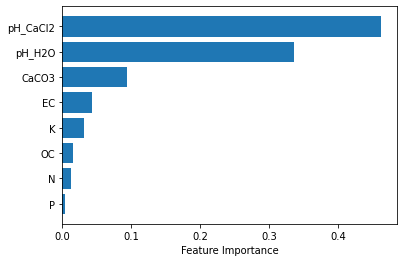

In [37]:
# now, lets run a few tests to determine the feature importance for the model. 

# part 1, using the randomforestclassifier model.

clf = RandomForestClassifier(random_state=0)

# Fit the classifier to the data
clf.fit(r, p['Relative Soil Fertility'])
sort = clf.feature_importances_.argsort()
plt.barh(r.columns[sort], clf.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.show()

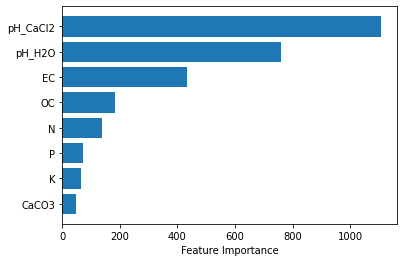

In [38]:
# part 2, using the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(r, p['Relative Soil Fertility'])
sort = clf.feature_importances_.argsort()
plt.barh(r.columns[sort], clf.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.show()

  <h2> Classification Model Class </h2>
  <pre> <h4> 
A class that defines our model (which is based upon the RandomForest Classifier),
and is a child class of the Data loading class. It contains all the functions, and 
parameters required for the model, including the evaluatemodel function,that scores 
the output on the F1 Scoring (between 0-1) and Accuracy % (between 0 - 100) metrics.</h4> </pre>

In [41]:

class classification(data):
    def __init__(classifier,algorithm = RandomForestClassifier()): # For now, taking input algorithm from the user as well, will implement selection later.
        super().__init__()
        classifier.model = algorithm
    def returndata(classifier):
        return [classifier.X,classifier.y]
    def initiateprocess(classifier):
        classifier.model.fit(classifier.X_train,classifier.y_train)
        classifier.pred = classifier.model.predict(classifier.X_test)
        return classifier
    def evaluatemodel(classifier):
        true= sum(np.asarray(classifier.y_test)==classifier.pred)
        totl = len(classifier.y_test)
        classifier.accuracy = true/totl
        ff = np.hsplit(classifier.y_test,9)
        fg = np.hsplit(classifier.pred,9)
        classifier.f1_scores = []
        for i in range(len(ff)):
            classifier.f1_scores.append(f1_score(ff[i],fg[i],average='macro'))
        print("F1 Score :",classifier.f1_scores)
        print("Accuracy % :",classifier.accuracy*100)
        return classifier




<h2> Explainable AI (XAI) Class </h2>

<pre> <h4>
This class defines the explainable aspect of the model. It tries to interpret the models output, 
using the shap library. Eventually, that graph shall be converted to a textual explaination. </h4> </pre>
    

In [39]:
class explain(classification):
    def __init__(xai,algorithm=RandomForestClassifier()):
        super().__init__(algorithm)
        xai.initiateprocess().evaluatemodel()
    def explaintome(xai): # for Randomforest scenario.
        print(" I am finding")
        j = 0
        r = xai.y_test.iloc[:,8].values
        for i in xai.X_test.index: # selects first zero value
            if(r[j] == 0):
                zero_val = xai.X_test.iloc[j].values
                zero_val_y = xai.y_test.iloc[j].values
                break
            j = j + 1
        k = 0
        for i in xai.X_test.index: # selects first zero value
            if(r[k] == 1):
                one_val = xai.X_test.iloc[k].values
                one_val_y = xai.y_test.iloc[k].values
                break
            k = k + 1
        p = 0
        for i in xai.X_test.index: # selects first zero value
            if(r[p] == 2):
                two_val = xai.X_test.iloc[p].values
                two_val_y = xai.y_test.iloc[p].values
                break
            p = p + 1
        print("i am running")
        explainer = sp.Explainer(xai.model)
        print("i am running x2")
        sv  = explainer(xai.X_test)
        print("i am running x3")

        sp.initjs()
        #sp.force_plot(explainer.expected_value[8], shap_values[8], chosen_sample, matplotlib=True,show=False)
        #shap_values  = explainer.shap_values(one_val)
        #sp.force_plot(explainer.expected_value[8], shap_values[8], chosen_sample, matplotlib=True,show=False)
        exp = sp.Explanation(sv[:,:,8], sv.base_values[:,8], xai.X_test, feature_names=xai.labels)
        print(zero_val, zero_val_y)
        waterfall_plot(exp[j])
        print(one_val, one_val_y)
        waterfall_plot(exp[k])
        print(two_val, two_val_y)
        waterfall_plot(exp[p])
      #  plt.savefig("fds4.jpg")
    def explaintomerf(xai): # for Randomforest scenario 2.
        print(" I am finding")
        j = 0
        r = xai.y_test.iloc[:,8].values
        for i in xai.X_test.index: # selects first zero value
            if(r[j] == 0):
                zero_val = xai.X_test.iloc[j].values
                zero_val_y = xai.y_test.iloc[j].values
                break
            j = j + 1
        k = 0
        for i in xai.X_test.index: # selects first zero value
            if(r[k] == 1):
                one_val = xai.X_test.iloc[k].values
                one_val_y = xai.y_test.iloc[k].values
                break
            k = k + 1
        p = 0
        for i in xai.X_test.index: # selects first zero value
            if(r[p] == 2):
                two_val = xai.X_test.iloc[p].values
                two_val_y = xai.y_test.iloc[p].values
                break
            p = p + 1
        print("i am running")
        explainer = sp.Explainer(xai.model)
        print("i am running x2")
        sv  = explainer(xai.X_test)
        print("i am running x3")

        sp.initjs()
        #sp.force_plot(explainer.expected_value[8], shap_values[8], chosen_sample, matplotlib=True,show=False)
        #shap_values  = explainer.shap_values(one_val)
        #sp.force_plot(explainer.expected_value[8], shap_values[8], chosen_sample, matplotlib=True,show=False)
        exp = sp.Explanation(sv[:,:,8], sv.base_values[:,8], xai.X_test, feature_names=xai.labels)
        print(zero_val, zero_val_y)
        waterfall_plot(exp[j])
        print(one_val, one_val_y)
        waterfall_plot(exp[k])
        print(two_val, two_val_y)
        waterfall_plot(exp[p])
      #  plt.savefig("fds4.jpg")
     
    def explaintome3(xai): # for knn scenario (error).
        print(" I am finding")
        j = 0
        r = xai.y_test.iloc[:,8].values
        for i in xai.X_test.index: # selects first zero value
            if(r[j] == 0):
                zero_val = xai.X_test.iloc[j].values
                zero_val_y = xai.y_test.iloc[j].values
                break
            j = j + 1
        k = 0
        for i in xai.X_test.index: # selects first zero value
            if(r[k] == 1):
                one_val = xai.X_test.iloc[k].values
                one_val_y = xai.y_test.iloc[k].values
                break
            k = k + 1
        p = 0
        for i in xai.X_test.index: # selects first zero value
            if(r[p] == 2):
                two_val = xai.X_test.iloc[p].values
                two_val_y = xai.y_test.iloc[p].values
                break
            p = p + 1
        print("i am running")
        explainer = sp.KernelExplainer(xai.model.predict_proba,xai.X_train)
        print("i am running x2")
        sv  = explainer.shap_values(xai.X_test)
        print("i am running x3")

        sp.initjs()
        #sp.force_plot(explainer.expected_value[8], shap_values[8], chosen_sample, matplotlib=True,show=False)
        #shap_values  = explainer.shap_values(one_val)
        #sp.force_plot(explainer.expected_value[8], shap_values[8], chosen_sample, matplotlib=True,show=False)
        exp = sp.Explanation(sv[:,:,8], sv.base_values[:,8], xai.X_test, feature_names=xai.labels)
        print(zero_val, zero_val_y)
        waterfall_plot(exp[j])
        print(one_val, one_val_y)
        waterfall_plot(exp[k])
        print(two_val, two_val_y)
        waterfall_plot(exp[p])
      #  plt.savefig("fds4.jpg")


<h1> Now, to run this program. </h1>

<pre> <h4> 
This section of the program contains the necessary driver functions needed to perform the classification and explaination of the output from the classification model. </h4> </pre>

<h4>  Random Forest Classifier </h4>

<h5> Using the Explainer function (output) </h5>

F1 Score : [0.9997107621448562, 0.9973801085191498, 0.8647443124185543, 0.9773704429713771, 0.8242822290500262, 0.794147431945532, 0.9827810454993615, 0.6508677748641356, 1.0]
Accuracy % : [ 99.97366342  99.73663418  98.31445878  99.42059521  79.37845668
  97.55069792  99.7102976   98.65683434 100.        ]
 I am finding
i am running
i am running x2
i am running x3


[ 3.3         4.02        8.12       37.1        96.13719811 16.9
  2.5        37.6       ] [0 0 0 1 0 0 0 0 0]


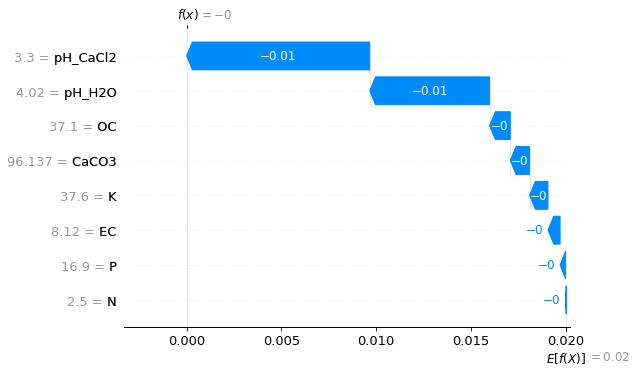

[  6.5          6.97         9.3         15.3         96.13719811
  17.5          1.8        155.6       ] [3 3 0 0 1 0 0 0 1]


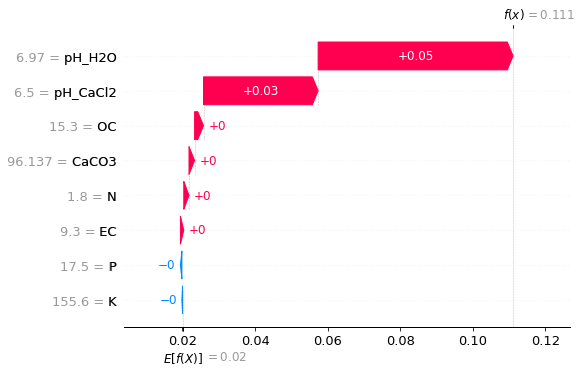

[  7.2    7.5   21.21   8.4    5.    49.2    0.9  127.4 ] [4 4 1 0 0 2 0 0 2]


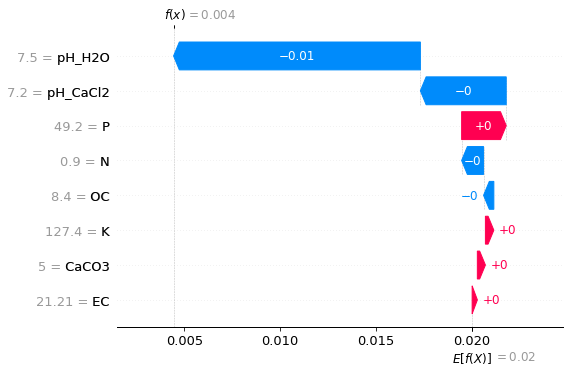

In [5]:
explain().explaintome() 

<h5> Using the TreeExplainer function (output) </h5>

F1 Score : [1.0, 0.9972899028322162, 0.7154953394305814, 0.9746090026001557, 0.8205140526601593, 0.7058463738145997, 0.9861383317416298, 0.8604506107965781, 1.0]
Accuracy % : [100.          99.73663418  98.63049776  99.47326837  79.08875428
  97.55069792  99.76297077  98.86752699 100.        ]
 I am finding
i am running
i am running x2
i am running x3


[  4.7    4.98  95.8   80.4    1.    46.6    6.3  185.5 ] [1 1 2 1 0 1 2 0 0]


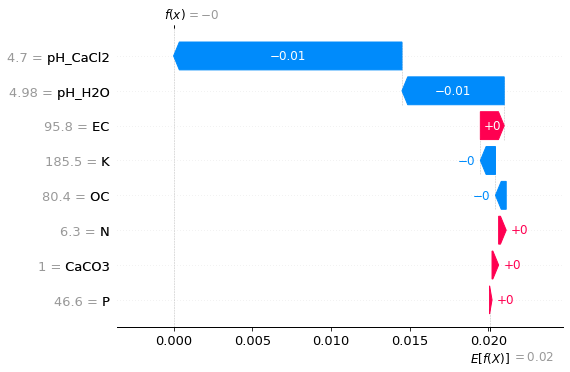

[  5.6    6.2   17.14  37.4    1.    13.5    4.6  120.7 ] [2 2 0 1 0 0 1 0 1]


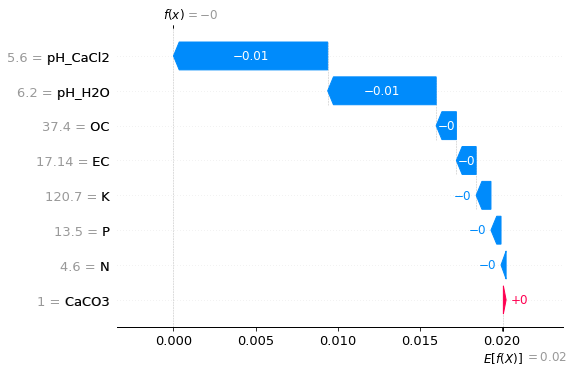

[  7.1    7.83  14.89  23.2  480.    13.2    2.4  507.1 ] [4 4 0 0 4 0 0 2 2]


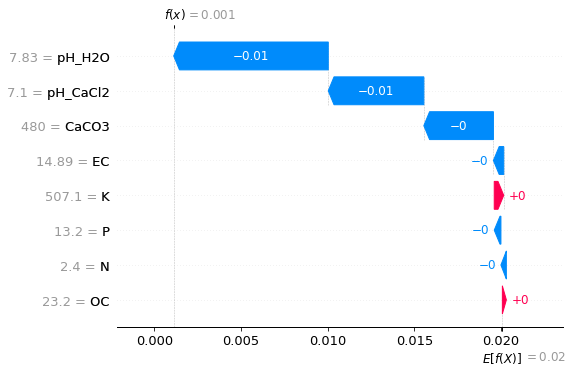

In [5]:
explain().explaintome()

<h4> K Neighbours Classifier </h4>

<h5> Using the KernelExplainer function (output) </h5>

In [42]:
explain(KNeighborsClassifier()).explaintome3() # leads to an error, thus discarding approach.

X has feature names, but KNeighborsClassifier was fitted without feature names


F1 Score : [0.5643311210806254, 0.5621379423172271, 0.7535494247546262, 0.9358786552117335, 0.7973017226524907, 0.7764815860796563, 0.7244995567456444, 0.9900716810181978, 0.7836241134607705]
Accuracy % : [59.15196208 58.75691335 83.67131946 95.47010798 76.03371082 88.14853832
 83.56597314 99.02554648 77.48222281]
 I am finding
i am running


AttributeError: 'list' object has no attribute 'shape'